## Volcano discovery with OGC WFS

### Introduction

Alice is a data scientist in an Italian public institution working in the volcanology thematic field. 

Alice has been tasked to contextualize with EO data and information the December 2018 eruptive event on the Etna. 

Alice knows that she may have to redo such a task for other eruptive events occurring on the Etna or on other active volcanoes

Alice decides to produce a set of Jupyter Notebooks using the Python kernel for all data discovery, processing and visualization tasks. 


### Use-case

Based on the assumption that Alice's work must be reproducible for other eruptive events on other active volcanoes, Alice implements a first Jupyter Notebook for the volcano discovery.

The Global Volcanism Program (GVP) of the Department Of Mineral Sciences from the National Museum Of Natural History of the Smithsonian Institution exposes OGC WFS services for the discovery of Holocene, Pleistocene and Holocene Volcanoes, of the Eruptions since 1960 and of the Emissions. 

Within the Jupyter Notebook for the volcano discovery, Alice consumes the GVP OGC WFS service for the discovery of the Etna volcano information. Since the Etna is an Holocene volcano, she uses the Holocene Volcanoes WFS layer. 

Using the OWSLib, a Python package for client programming with Open Geospatial Consortium (OGC) web service (hence OWS) interface standards and their related content models, Alice queries the WFS layer using the name queryable. The format returned is JSON, a format quite easy to deserialize into a simple geo dataframe containing the information about the Etna volcano.

While Alice is mostly interested in the Etna volcano geolocation, the information returned by the GVP WFS response contains a rich set of information such as the Etna volcano number, a unique identifier widely used by the volcanologists community.



### Workflow

Import the modules 

In [1]:
from owslib.wfs import WebFeatureService
from owslib.etree import etree
from owslib.fes import PropertyIsEqualTo
import json
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import shape
import os

Create _WebFeatureService_ pointing at the Global Volcanism Program Web Feature Service endpoint

In [2]:
wfs11 = WebFeatureService(url='https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?', version='1.1.0')

Show the service information

In [3]:
wfs11.identification.title

'GeoServer Web Feature Service'

In [4]:
[operation.name for operation in wfs11.operations]

['GetCapabilities', 'DescribeFeatureType', 'GetFeature', 'GetGmlObject']

List the WFS Features

In [5]:
list(wfs11.contents)

['GVP-VOTW:E3WebApp_EmissionPixels',
 'GVP-VOTW:E3WebApp_Emissions',
 'GVP-VOTW:E3WebApp_Eruptions1960',
 'GVP-VOTW:E3WebApp_HoloceneVolcanoes',
 'GVP-VOTW:Smithsonian_VOTW_Holocene_Eruptions',
 'GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes',
 'GVP-VOTW:Smithsonian_VOTW_Pleistocene_Volcanoes']

Get the information about the Etna

In [6]:
volcano_name = 'Etna' 

Create a WFS filter

In [7]:
filter = PropertyIsEqualTo(propertyname='Volcano_Name', 
                           literal=volcano_name)

filterxml = etree.tostring(filter.toXML()).decode("utf-8")

Query the WFS and parse the response

In [8]:
response = wfs11.getfeature(typename='GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes', 
                            filter=filterxml,
                            outputFormat='JSON')

features = json.loads(response.getvalue())['features']

Features found:

In [9]:
len(features)

1

In [10]:
volcanoes = gpd.GeoDataFrame([features[0]], columns=features[0].keys())

In [11]:
volcanoes

type                                                 id  \
0  Feature  Smithsonian_VOTW_Holocene_Volcanoes.fid-1fba15...   

                                            geometry geometry_name  \
0  {'type': 'Point', 'coordinates': [14.999, 37.7...   GeoLocation   

                                          properties  
0  {'Volcano_Number': 211060, 'Volcano_Name': 'Et...

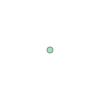

In [12]:
shape(json.loads(json.dumps(volcanoes.iloc[0].geometry)))

In [13]:
def to_geometry(row):
    
    return shape(json.loads(json.dumps(row.geometry)))


In [14]:
volcanoes['geometry'] = volcanoes.apply(lambda row: to_geometry(row), axis=1)

In [15]:
volcanoes

type                                                 id  \
0  Feature  Smithsonian_VOTW_Holocene_Volcanoes.fid-1fba15...   

                geometry geometry_name  \
0  POINT (14.999 37.748)   GeoLocation   

                                          properties  
0  {'Volcano_Number': 211060, 'Volcano_Name': 'Et...

In [16]:
volcanoes.iloc[0]['geometry'].wkt

'POINT (14.999 37.748)'

Get the Etna volcano properties:

In [17]:
volcano_prop = gpd.GeoDataFrame([features[0]['properties']], columns=features[0]['properties'].keys())

In [18]:
volcano_prop

Volcano_Number Volcano_Name Primary_Volcano_Type  Last_Eruption_Year  \
0          211060         Etna    Stratovolcano(es)                2020   

  Country                                 Geological_Summary  \
0   Italy  Mount Etna, towering above Catania, Sicily's s...   

                           Region Subregion  Latitude  Longitude  Elevation  \
0  Mediterranean and Western Asia     Italy    37.748     14.999       3295   

                                Tectonic_Setting Geologic_Epoch  \
0  Subduction zone / Continental crust (> 25 km)       Holocene   

   Evidence_Category                             Primary_Photo_Link  \
0  Eruption Observed  https://volcano.si.edu/photos/full/015052.jpg   

                               Primary_Photo_Caption  \
0  Etna is Europe's highest volcano, towering abo...   

                                Primary_Photo_Credit  \
0  Photo by Jean-Claude Tanguy, 1991 (University ...   

                    Major_Rock_Type  
0  Trachybasalt / Tephrite Basanite

Merge the properties

In [19]:
def expand_properties(row):
    
    return pd.Series(row['properties'])

In [20]:
volcanoes.apply(lambda row: expand_properties(row), axis=1)

Volcano_Number Volcano_Name Primary_Volcano_Type  Last_Eruption_Year  \
0          211060         Etna    Stratovolcano(es)                2020   

  Country                                 Geological_Summary  \
0   Italy  Mount Etna, towering above Catania, Sicily's s...   

                           Region Subregion  Latitude  Longitude  Elevation  \
0  Mediterranean and Western Asia     Italy    37.748     14.999       3295   

                                Tectonic_Setting Geologic_Epoch  \
0  Subduction zone / Continental crust (> 25 km)       Holocene   

   Evidence_Category                             Primary_Photo_Link  \
0  Eruption Observed  https://volcano.si.edu/photos/full/015052.jpg   

                               Primary_Photo_Caption  \
0  Etna is Europe's highest volcano, towering abo...   

                                Primary_Photo_Credit  \
0  Photo by Jean-Claude Tanguy, 1991 (University ...   

                    Major_Rock_Type  
0  Trachybasalt / Tephrite Basanite

In [21]:
volcanoes = volcanoes.merge(volcanoes.apply(lambda row: expand_properties(row), axis=1), 
              left_index=True,
              right_index=True)

In [22]:
volcanoes

type                                                 id  \
0  Feature  Smithsonian_VOTW_Holocene_Volcanoes.fid-1fba15...   

                    geometry geometry_name  \
0  POINT (14.99900 37.74800)   GeoLocation   

                                          properties  Volcano_Number  \
0  {'Volcano_Number': 211060, 'Volcano_Name': 'Et...          211060   

  Volcano_Name Primary_Volcano_Type  Last_Eruption_Year Country  ... Latitude  \
0         Etna    Stratovolcano(es)                2020   Italy  ...   37.748   

  Longitude Elevation                               Tectonic_Setting  \
0    14.999      3295  Subduction zone / Continental crust (> 25 km)   

   Geologic_Epoch  Evidence_Category  \
0        Holocene  Eruption Observed   

                              Primary_Photo_Link  \
0  https://volcano.si.edu/photos/full/015052.jpg   

                               Primary_Photo_Caption  \
0  Etna is Europe's highest volcano, towering abo...   

                                Primary_Photo_Credit  \
0  Photo by Jean-Claude Tanguy, 1991 (University ...   

                    Major_Rock_Type  
0  Trachybasalt / Tephrite Basanite  

[1 rows x 23 columns]

Show some information about the volcano:

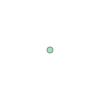

In [23]:
volcanoes.iloc[0].geometry

In [24]:
volcanoes.iloc[0]['Volcano_Number'] 

211060

In [25]:
volcanoes.iloc[0]['Primary_Photo_Link']

'https://volcano.si.edu/photos/full/015052.jpg'

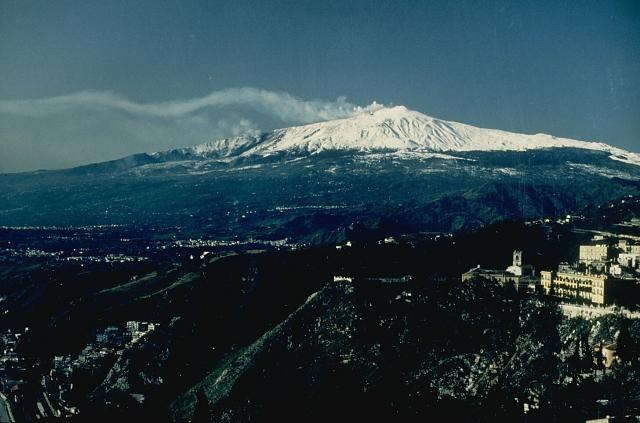

In [26]:
from IPython.display import Image
Image(volcanoes.iloc[0]['Primary_Photo_Link']) 

Save as a geojson file

In [27]:
if os.path.exists('volcanoes.geojson'):
    
    os.remove('volcanoes.geojson')

volcanoes.to_file('volcanoes.geojson', driver='GeoJSON')